---

# Comparative Behaviour of One-Class Anomaly Detectors on Controlled Network Flow Data (workbook)

---

***This notebook documents an exploratory, pedagogical investigation into anomaly detection on network flows, undertaken to validate understanding and compare modelling choices in a controlled lab setting.***

***This notebook uses data generated from functions written for the repo. See*** `README.txt` ***for more information.***

This notebook explores how two one-class anomaly detectors —

- **Isolation Forest**
- **One-Class SVM**

— behave on a **synthetic but controlled** network flow dataset derived from local traffic captures.

These two algorithms represent different classes of anomaly detection methods that may plausibly serve as components within intrusion detection systems (IDS), occupying different roles depending on data volume, latency constraints and tolerance for false positives.

---


## 1. Experiment Objectives

The purpose of this notebook is to **validate and interpret the behaviour of simple one-class anomaly detectors on network flow features**, rather than to build an operational intrusion detection system. A secondary goal is to compare these two algorithmic approaches in order to understand their relative strengths, weaknesses and potential placement within a broader detection pipeline, rather than to identify a single “best” model.

>**Design choice: one-class models and explicit calibration**
>
>This project deliberately avoids supervised classification. In realistic defensive settings, labelled attack data are scarce, incomplete or biased, while benign traffic is abundant. One-class models allow learning a baseline of normal behaviour and make assumptions explicit.
>
>Equally, model scores alone are not actionable without thresholds. For this reason, emphasis was placed on **calibrating decision thresholds against target false-positive rates**, reflecting operational trade-offs rather than abstract accuracy metrics.

Specifically, this notebook (in Section 4) will:

1. **Load and inspect the demo datasets**

   - `normal_flows.csv` → flows derived from local HTTP traffic  
   - `scan_flows.csv` → flows derived from a local SYN scan (equivalent of `nmap -sS`)
   - Confirm schema consistency and basic feature sanity before modelling

2. **Perform a sanity check against observed CLI behaviour**

   - Verify that scan-like traffic remains distinguishable after feature extraction  
   - Confirm that the Python-based pipeline reproduces patterns previously observed at the command line  
   - Rule out obvious pipeline or aggregation errors before evaluation

3. **Algorithm comparison I: Benchmark model behaviour as a function of training size**

   - Train Isolation Forest and One-Class SVM models on increasing subsets of normal traffic  
   - Examine detection stability, recall and computational cost as data volume increases  
   - Identify regimes where each model becomes unstable or impractical

4. **Algorithm comparison II: Calibrate decision thresholds under low false-positive constraints**

   - Use raw `decision_function` scores rather than hard labels  
   - Compare default thresholds with thresholds calibrated to a target false-positive rate (FPR) on normal flows  
   - Observe how recall and precision change as thresholds are adjusted

5. **Algorithm comparison III: Analyse and visualise anomaly score distributions**

   - Inspect score separation between normal and scan flows  
   - Use visualisation to interpret why certain thresholds succeed or fail  
   - Support quantitative results with qualitative understanding of model behaviour

A larger, separate dataset of normal flows is also used for speed benchmarking:

- `tests/speedtest/data/features/normal_flows.csv`

The goal is **not** to maximise detection performance — both models perform almost perfectly in this clean setting — but to:

- develop intuition about **how one-class models behave** on network flow features  
- understand the impact of **training size and threshold calibration** on detection outcomes  
- gain an initial sense of **speed versus flexibility** when choosing between Isolation Forest and One-Class SVM

This notebook serves as a first-pass “pressure test” on clean, controlled data, establishing a baseline before intentionally introducing more realistic noise and complexity in later experiments.

---

## 2. Data description

The flows used here were generated in a **fully controlled lab environment** using the CLI tools included in the repo (see `README.txt`):

- **Normal flows**:
  - Local HTTP server (`python -m http.server 8000`)
  - Many short HTTP/1.0 requests with `Connection: close`
  - Encourages lots of **independent flows** rather than a single long-lived connection

- **Scan flows**:
  - Local SYN scan over a range of ports (e.g. 1–2000)
  - Produces **many short, often incomplete TCP flows** (SYN / SYN-ACK / RST patterns)

The feature extraction pipeline:

1. `tshark` exports per-packet fields to CSV.  
2. `pcap2features.py` aggregates to per-flow features, including:
   - total packets, total bytes
   - flow duration
   - inter-arrival time statistics
   - TCP flag counts
   - number of unique destination ports, etc.

For this notebook, we’ll:

- Load `normal_flows.csv` and `scan_flows.csv` from `data/demo/features/`
- Attach a simple label: `0 = normal`, `1 = anomaly (scan)`
- Perform sanity checks on shapes, feature distributions and basic summary stats.

---

## 3. One-class anomaly detection models

This section briefly summarises the models used in the analysis and the assumptions they make about normal and anomalous behaviour.

We’re working with two standard one-class anomaly detectors:

### 3.1 Isolation Forest

- Builds many random trees on the normal data.
- Points that are **isolated very quickly** in the trees are treated as anomalies.
- Key parameters:
  - `contamination`: expected fraction of anomalies (influences score scaling)
  - `n_estimators`, `max_samples`, etc. (these will be kept at sensible defaults)

Why it’s nice here:

- Handles unscaled numeric features reasonably well.
- Fast and robust on tabular data.
- Produces a **decision_function** where larger values ≈ more normal.

### 3.2 One-Class SVM (RBF kernel)

- Learns a **smooth boundary** around the cloud of normal points.
- Anything far outside this boundary gets a negative score (anomaly).
- Key parameters:
  - `nu`: upper bound on fraction of training outliers + margin parameter
  - `gamma`: controls how “wiggly” the boundary is (via the RBF kernel)
- We apply a robust scaler first so no single feature dominates distances.

Why it’s interesting:

- More expressive boundary; can model more complex “normal” shapes.
- More sensitive to hyperparameters and scaling, which makes it a good candidate for this kind of controlled exploration.

In both cases, we’ll look directly at the **decision_function** scores and see how they separate normal vs. scan flows.

---

## 4. Analysis

This section follows the analysis plan outlined above, progressing from basic data checks through benchmarking, calibration, and score interpretation.

### 4.1 Load and inspect data

- Load `normal_flows.csv` and `scan_flows.csv` from `data/demo/features/`.
- Confirm:
  - number of flows per class
  - that feature schemas are consistent across datasets
  - that no obvious data quality issues prevent modelling (e.g. missing values)

We will **not** do heavy feature engineering here; the goal is to keep the setup simple and transparent and focus on model behaviour rather than feature optimisation.


In [8]:
# --- Importing data
from pathlib import Path
import pandas as pd

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "data").exists() is False:
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "features"

normal_flows = pd.read_csv(DATA_DIR / "normal_flows.csv")
scan_flows = pd.read_csv(DATA_DIR / "scan_flows.csv")

The head and shape of `normal_flows.csv`:

In [2]:
# --- Printing "normal flows" data
print(f"Data dimensions: ", {normal_flows.shape})
normal_flows.head(n = 3)

Data dimensions:  {(400, 27)}


,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,packet_count,bytes_total,bytes_mean,bytes_std,...,last_seen,duration,tcp_fin_count,tcp_syn_count,tcp_rst_count,tcp_psh_count,tcp_ack_count,tcp_urg_count,tcp_ece_count,tcp_cwr_count
0,127.0.0.1-44898-127.0.0.1-8000-tcp,127.0.0.1,44898,127.0.0.1,8000,tcp,6,501,83.5,39.078127,...,0.002074,0.002074,1,1,0,1,5,0,0,0
1,127.0.0.1-8000-127.0.0.1-44898-tcp,127.0.0.1,8000,127.0.0.1,44898,tcp,6,2205,367.5,661.061495,...,0.002141,0.002103,1,1,0,2,6,0,0,0
2,127.0.0.1-44908-127.0.0.1-8000-tcp,127.0.0.1,44908,127.0.0.1,8000,tcp,6,501,83.5,39.078127,...,0.013240,0.001284,1,1,0,1,5,0,0,0


The head and shape of the `scan_flows.csv`:

In [3]:
# --- Printing "scan flows" data
print(f"Data dimensions: ", {scan_flows.shape})
scan_flows.head(n = 3)

Data dimensions:  {(4000, 27)}


,flow_id,src_ip,src_port,dst_ip,dst_port,protocol,packet_count,bytes_total,bytes_mean,bytes_std,...,last_seen,duration,tcp_fin_count,tcp_syn_count,tcp_rst_count,tcp_psh_count,tcp_ack_count,tcp_urg_count,tcp_ece_count,tcp_cwr_count
0,127.0.0.1-46688-127.0.0.1-1720-tcp,127.0.0.1,46688,127.0.0.1,1720,tcp,1,58,58.0,0.0,...,0.000000,0.0,0,0,0,0,0,0,0,0
1,127.0.0.1-1720-127.0.0.1-46688-tcp,127.0.0.1,1720,127.0.0.1,46688,tcp,1,54,54.0,0.0,...,0.000021,0.0,0,0,0,0,0,0,0,0
2,127.0.0.1-46688-127.0.0.1-21-tcp,127.0.0.1,46688,127.0.0.1,21,tcp,1,58,58.0,0.0,...,0.000030,0.0,0,0,0,0,0,0,0,0


From these outputs we can see that the datasets are structurally analogous in terms of shapes and schema. Next we'll check there are no obvious pathologies:

In [4]:
# --- Basic schema and data quality checks
cols_match = set(normal_flows.columns) == set(scan_flows.columns)
nans_normal = normal_flows.isna().sum().sum()
nans_scan = scan_flows.isna().sum().sum()

print(
    f"Column names correspond: {cols_match} "
    f"\nNormal flows NaNs: {nans_normal} "
    f"\nScan flows NaNs: {nans_scan}"
)


Column names correspond: True 
Normal flows NaNs: 0 
Scan flows NaNs: 0




From this we can be sure that both datasets are ready to be used for training and proceed to the next subsection.

---


### 4.2 Train baseline models

The anomaly detection models used here were originally implemented as command-line tools, designed to run passively as part of a longer-lived detection workflow rather than being applied post hoc within an interactive analysis environment.

Before proceeding to systematic benchmarking, we'll perform a brief consistency check to ensure that model behaviour in this notebook matches that observed in the CLI-based implementation (see `README.txt` in the repository). This section also makes explicit the default parameterisation used for each model.

For each model (Isolation Forest and One-Class SVM):

- Train on **normal flows only** (or a train-split of them).
- Evaluate on:
  - hold-out normal flows
  - all scan flows

We’ll start with default-ish parameters:

- Isolation Forest: `contamination ≈ 0.05`
- OCSVM: `nu = 0.05`, `gamma = "scale"`

Then we’ll:

- capture precision, recall, F1
- look at the confusion matrix (TP/FP/TN/FN)

In [9]:
# --- Importing the models:
import sys
from pathlib import Path

# Resolve project root (repo root)
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.append(str(PROJECT_ROOT / "src"))

import train_iforest, train_ocsvm

Below are the outputs of the Isolation Forest and One-Class SVM models, trained on the same data and parameters as in the CLI. We can see that, as a sanity check, the performance is very similar to that of the CLI:

In [11]:
# --- Train and test Isolation Forest
from pathlib import Path

DEMO_DIR = PROJECT_ROOT / "data" / "demo" / "features"
NORMAL = DEMO_DIR / "normal_flows.csv"
ANOMALY = DEMO_DIR / "scan_flows.csv"

missing = [p for p in (NORMAL, ANOMALY) if not p.exists()]
if missing:
    raise FileNotFoundError(
        "Missing expected demo files:\n" + "\n".join(str(p) for p in missing)
    )

result_iforest = train_iforest.train_iforest_pipeline(
    normal=str(NORMAL),
    anomaly=str(ANOMALY),
    outdir=str(PROJECT_ROOT / "models_iforest_demo"),
    contamination=0.05,
    train_frac=0.8,
    target_fpr=None,
    summary=True,
)

[+] Model saved to /Users/mukappa/Desktop/Kali_share/ds-cyber-pcap-oc/models_iforest_demo/iforest.pkl
[+] Threshold: 0.00000 (target_fpr=None)
[+] Features used: 19
[+] Train normals: 320 | Holdout normals: 80 | Anomalies: 4000
[+] Eval samples: 4080 — TP:4000 FP:3 TN:77 FN:0
[+] Precision: 0.999 Recall: 1.000 F1: 1.000


In [12]:
# --- Train and test OCSVM
result_ocsvm = train_ocsvm.train_ocsvm_pipeline(
    normal=str(NORMAL),
    anomaly=str(ANOMALY),
    outdir=str(PROJECT_ROOT / "models_ocsvm_demo"),
    train_frac=0.8,
    nu=0.05,
    gamma="scale",
    target_fpr=None,
    summary=True,
)

[+] Model saved to /Users/mukappa/Desktop/Kali_share/ds-cyber-pcap-oc/models_ocsvm_demo/ocsvm.pkl
[+] OCSVM params — nu: 0.05  gamma: scale  (resolved: 0.13792)
[+] Threshold: 0.00000  (target_fpr=None)
[+] Features used: 19
[+] Train normals: 320 | Holdout normals: 80 | Anomalies: 4000
[+] Eval samples: 4080 — TP:4000 FP:3 TN:77 FN:0
[+] Precision: 0.999  Recall: 1.000  F1: 1.000


With baseline behaviour confirmed, we will now examine how model performance and stability vary with training size.

---

### 4.3 Training-size benchmarking (speed and stability)

Here, we perform a controlled benchmarking experiment to understand how **training size affects both computational cost and detection behaviour** for each model. A larger normal flow dataset was created for this test using the `generate_normal.sh` function in the CLI, yielding approximately 7200 flows:

> generate_normal.sh 4096 300

The procedure is as follows:

- Fix a **single normal holdout set** (1000 flows), used consistently for:
  - threshold calibration (`target_fpr`)
  - evaluation
- Use the remaining normal flows as a **training pool**
- For each iteration $i = 0 \ldots 5$:
  - Randomly sample $\lfloor N / 2^i \rfloor$ normal flows from the training pool
  - Train the model on this subset only
  - Evaluate on:
    - the fixed normal holdout set
    - the full anomaly (scan) dataset

For each training size we measure:

- **Training time** (`fit`)  
- **Inference time** (`decision_function` on holdout normals + anomalies)
- Detection metrics (with anomaly treated as the positive class), including PPV, NPV, recall, F1, and FPR

Each configuration is repeated multiple times (in this instance, 30), and **median values** are reported to reduce noise from random subsampling.

Although absolute runtimes are small in this synthetic setting, the experiment reveals:
- how training and inference costs scale with data volume
- how each model degrades, in terms of stability and recall, as normal training data becomes scarce

This provides a reusable benchmarking framework that can be applied unchanged to larger datasets or more challenging traffic patterns in later analyses.


In [14]:
# --- Importing functions and datasets:
import math
import time
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# deconstructed, slimlined train and test functions based on the train_* pipelines
import speedtest_src as st  # in local src directory

speedtest_train = "/tests/speedtest/data/features/normal_flows.csv" # for example, but already declared in speedtest_src
speedtest_eval  = "/tests/speedtest/data/features/scan_flows.csv"


In [15]:
# --- Benchmarking of IF vs OCSVM as training set size shrinks (i=0..5)
# - Allocate 1000 obs as a FIXED holdout set (normals only)
# - Each iteration samples floor(N_trainpool / 2^i) rows from the remaining NORMAL pool
# - Evaluates on: (fixed normal holdout) + (all scan flows)
# - Captures: fit time, inference time, PPV/NPV/Recall/F1, FPR
# - Positive class = anomaly (1)

import math
import time
import numpy as np
import pandas as pd
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "tests").exists() and (PROJECT_ROOT.parent / "tests").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

NORMAL_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "normal_flows.csv"
ANOM_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "scan_flows.csv"

# ---- controls ----
iters = list(range(6))
reps = 30 # number of training/evaluation runs for each dataset size (for benchmarking)
target_fpr = None # e.g., 0.01 or None for 0.0
holdout_n = 1000
rng = np.random.default_rng(42)

# ---- load datasets ----
df_norm_all = st.load_features(NORMAL_PATH)
df_anom_all = st.load_features(ANOM_PATH)

df_norm_all = df_norm_all.sample(frac=1.0, random_state=42).reset_index(drop=True)

df_hold_fixed = df_norm_all.iloc[:holdout_n].copy()
df_trainpool  = df_norm_all.iloc[holdout_n:].copy()

X_hold_fixed = st.select_feature_matrix(df_hold_fixed)
X_anom_all   = st.select_feature_matrix(df_anom_all)

N_trainpool = len(df_trainpool)

def _median(vals):
    return float(np.median(np.asarray(vals, dtype=float)))

def benchmark_one_model(model_name: str):
    rows = []

    for i in iters:
        n_train = max(2, min(math.floor(N_trainpool / (2 ** i)), N_trainpool))

        fit_times, infer_times = [], []
        ppvs, npvs, recalls, f1s, fprs = [], [], [], [], []

        for _ in range(reps):
            # ---- sample training data ----
            idx_train = rng.choice(N_trainpool, size=n_train, replace=False)
            X_train = st.select_feature_matrix(df_trainpool.iloc[idx_train])

            # ---- FIT ----
            t0 = time.perf_counter()
            if model_name == "iforest":
                model = st.fit_iforest(X_train, contamination=0.05)
            elif model_name == "ocsvm":
                model = st.fit_ocsvm(X_train, nu=0.05, gamma="scale")
            else:
                raise ValueError("Unknown model_name")
            t1 = time.perf_counter()
            fit_times.append(t1 - t0)

            # ---- INFERENCE ----
            t2 = time.perf_counter()

            scores_norm = model.decision_function(X_hold_fixed)
            scores_anom = model.decision_function(X_anom_all)

            if target_fpr is not None and 0.0 < target_fpr < 0.5:
                thresh = float(np.quantile(scores_norm, target_fpr))
            else:
                thresh = 0.0

            y_true = np.concatenate([
                np.zeros(len(scores_norm), dtype=int),
                np.ones(len(scores_anom), dtype=int)
            ])

            scores_eval = np.concatenate([scores_norm, scores_anom])
            y_pred = (scores_eval < thresh).astype(int)

            tp = int(((y_pred == 1) & (y_true == 1)).sum())
            fp = int(((y_pred == 1) & (y_true == 0)).sum())
            tn = int(((y_pred == 0) & (y_true == 0)).sum())
            fn = int(((y_pred == 0) & (y_true == 1)).sum())

            # ---- metrics ----
            ppv = tp / (tp + fp) if (tp + fp) else 0.0   # precision
            npv = tn / (tn + fn) if (tn + fn) else 0.0
            rec = tp / (tp + fn) if (tp + fn) else 0.0
            f1  = (2 * ppv * rec) / (ppv + rec) if (ppv + rec) else 0.0
            fpr = fp / (fp + tn) if (fp + tn) else 0.0

            t3 = time.perf_counter()
            infer_times.append(t3 - t2)

            ppvs.append(ppv)
            npvs.append(npv)
            recalls.append(rec)
            f1s.append(f1)
            fprs.append(fpr)

        rows.append({
            "model": model_name,
            "positive_class": "anomaly",
            "i": i,
            "n_train": int(n_train),
            "n_hold": int(holdout_n),
            "fit_time_md": _median(fit_times),
            "infer_time_md": _median(infer_times),
            "ppv_md": _median(ppvs),
            "npv_md": _median(npvs),
            "recall_md": _median(recalls),
            "f1_md": _median(f1s),
            "fpr_md": _median(fprs),
        })

    return pd.DataFrame(rows)

df_if  = benchmark_one_model("iforest")
df_svm = benchmark_one_model("ocsvm")
df = pd.concat([df_if, df_svm], ignore_index=True)

In [16]:
# --- Outputting the results table:
display(df)

,model,positive_class,i,n_train,n_hold,fit_time_md,infer_time_md,ppv_md,npv_md,recall_md,f1_md,fpr_md
0,iforest,anomaly,0,6206,1000,0.205513,0.026669,0.975852,0.328028,0.514250,0.673543,0.0500
1,iforest,anomaly,1,3103,1000,0.173318,0.026449,0.976996,0.328786,0.514750,0.674091,0.0480
2,iforest,anomaly,2,1551,1000,0.155092,0.026443,0.975691,0.327572,0.513500,0.672608,0.0505
3,iforest,anomaly,3,775,1000,0.146008,0.026496,0.974196,0.325392,0.513500,0.671351,0.0545
4,iforest,anomaly,4,387,1000,0.141175,0.026525,0.971509,0.326685,0.514250,0.673708,0.0565
5,iforest,anomaly,5,193,1000,0.141441,0.027681,0.958079,0.274324,0.375125,0.539498,0.0610
6,ocsvm,anomaly,0,6206,1000,0.081816,0.062860,0.957625,1.000000,1.000000,0.978354,0.1770
7,ocsvm,anomaly,1,3103,1000,0.019587,0.032360,0.988501,1.000000,1.000000,0.978086,0.0360
8,ocsvm,anomaly,2,1551,1000,0.006799,0.017017,0.817327,1.000000,1.000000,0.899483,0.0365
9,ocsvm,anomaly,3,775,1000,0.003466,0.009323,0.810456,0.201035,0.031000,0.059537,0.0420


**Metric definitions for the data are provided in the Appendix.**

### Isolation Forest vs One-Class SVM (positive class = anomaly)

These results show a clear trade-off between **computational scaling** and **detection stability** as the amount of *normal* training data shrinks.

### Speed results

#### Training time (fit)
- **OCSVM** is faster to train at small and medium sizes, but its fit time grows rapidly with training size (superlinear trend).
- **Isolation Forest** trains more slowly at small sizes but scales smoothly and predictably.

**Interpretation:** OCSVM can be attractive when training sets are small or retraining must be very fast, but Isolation Forest is the more scalable, predictable option as data volume grows.

#### Inference time (decision_function on holdout + all anomalies)
- **Isolation Forest** inference time remains approximately constant across training sizes.
- **OCSVM** inference time increases noticeably with training size and eventually becomes slower than IF.

**Interpretation:** For live scoring or high-throughput pipelines, Isolation Forest’s stability is an operational advantage.

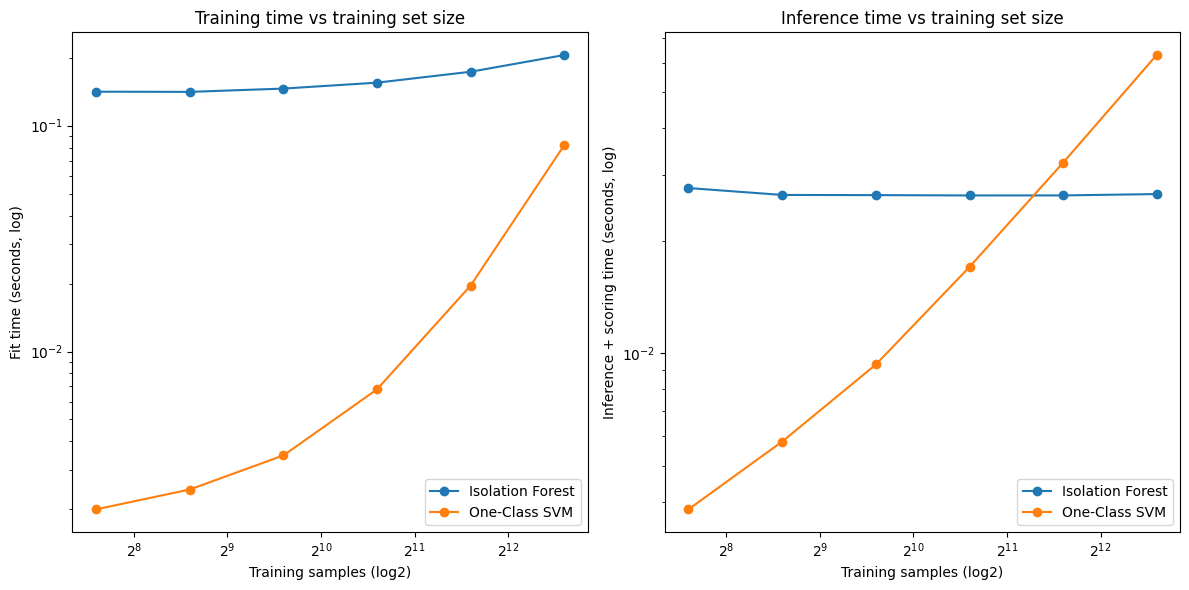

In [17]:
# --- Timing plots

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

label_map = {
    "iforest": "Isolation Forest",
    "ocsvm": "One-Class SVM"
}

# 1) Fit time vs train size
ax = axes[0]
for name, sub in df.groupby("model"):
    ax.plot(
        sub["n_train"],
        sub["fit_time_md"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Training samples (log2)")
ax.set_ylabel("Fit time (seconds, log)")
ax.set_title("Training time vs training set size")
ax.legend(loc="lower right")

# 2) Inference time vs train size
ax = axes[1]
for name, sub in df.groupby("model"):
    ax.plot(
        sub["n_train"],
        sub["infer_time_md"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Training samples (log2)")
ax.set_ylabel("Inference + scoring time (seconds, log)")
ax.set_title("Inference time vs training set size")
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


Taken together, the timing results indicate a crossover in computational cost: while the One-Class SVM is more efficient at small training sizes, both its training and inference costs grow rapidly with data volume. Beyond approximately $2^{12}$–$2^{13}$ training samples, this erodes its early advantage relative to Isolation Forest, whose scaling remains comparatively stable.

Given that both models achieve similarly high detection performance on this clean synthetic task, the more interesting question is how their *detection behaviour* degrades as normal training data becomes scarce. This is examined next.


### Detection performance (positive = anomaly)

#### Isolation Forest
- **PPV (precision)** remains high (~0.97) for most training sizes, dropping only at the smallest size.
- **Recall** is consistently moderate (~0.51), declining primarily at the smallest training size.
- **FPR** increases gradually as training size shrinks.

**Interpretation:** Isolation Forest is conservative and stable. It maintains low false-positive rates but misses a meaningful fraction of anomalies, with performance degrading smoothly as normal training data becomes scarce.

#### One-Class SVM
- With larger training sets (≈6206, 3103, 1551):
  - **Recall = 1.0**, **NPV = 1.0**, indicating very strong separation.
- Below ~1000 training samples (≈775 and smaller):
  - **Recall drops sharply** to ~1–3%, **F1 becomes unusable**, and **PPV also declines**.

**Interpretation:** One-Class SVM is highly sensitive to under-training. When sufficient normal data are available it performs extremely well, but its failure mode is abrupt and brittle as training data shrinks.



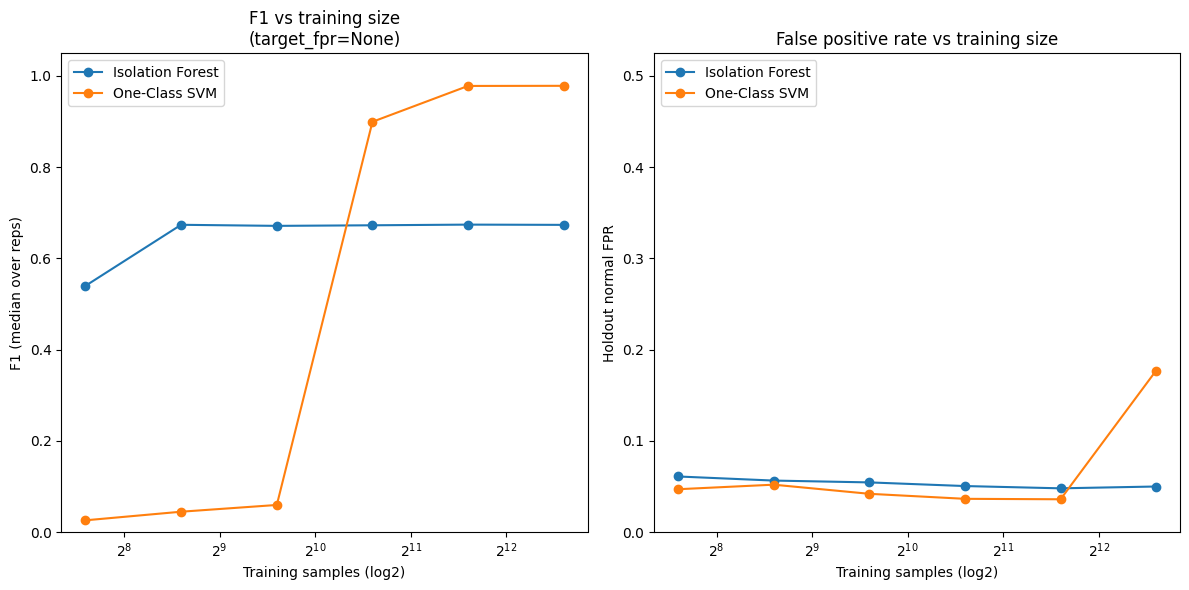

In [18]:
# --- F1 and FPR performance plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

label_map = {
    "iforest": "Isolation Forest",
    "ocsvm": "One-Class SVM"
}

# -------------------------------------------------
# Left: F1 vs training size
# -------------------------------------------------
ax = axes[0]
for name, sub in df.groupby("model"):
    ax.plot(sub["n_train"], sub["f1_md"], marker="o", label=label_map.get(name, name))

ax.set_xscale("log", base=2)
ax.set_xlabel("Training samples (log2)")
ax.set_ylabel("F1 (median over reps)")
ax.set_title(f"F1 vs training size\n(target_fpr={target_fpr})")
ax.set_ylim(0, 1.05)
ax.legend(loc = "upper left")

# -------------------------------------------------
# Right: FPR vs training size
# -------------------------------------------------
ax = axes[1]
for name, sub in df.groupby("model"):
    ax.plot(sub["n_train"], sub["fpr_md"], marker="o", label=label_map.get(name, name))

ax.set_xscale("log", base=2)
ax.set_xlabel("Training samples (log2)")
ax.set_ylabel("Holdout normal FPR")
ax.set_title("False positive rate vs training size")
ax.set_ylim(0, 0.525)
ax.legend(loc = "upper left")

plt.tight_layout()
plt.show()


We now move onto the threshold calibration experiments.

---

### 4.4 Threshold calibration experiments

To examine how sensitive each model is to the choice of decision threshold, we'll run a controlled threshold calibration experiment with training size held fixed.

The procedure is as follows:

- Fix the normal training set size to $2^{12}$ (4096 flows), a regime in which both models previously showed strong and stable performance, allowing threshold effects to be examined independently of under-training.
- Reserve a **separate, fixed normal holdout set** (1000 flows), used exclusively for:
  - threshold calibration
  - evaluation on normal data
- Use the full set of scan flows as the anomaly evaluation set.

For each model, we:

- Train once per repetition on a random sample of 4096 normal flows.
- Compute decision scores on the fixed normal holdout set.
- Derive decision thresholds using quantiles of the holdout score distribution, corresponding to target false positive rates  

$$\text{target}_{\mathrm{FPR}} \in \left\{ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1 \right\}$$
- Apply each threshold to the combined evaluation set (holdout normals + all anomalies).

At each threshold we measure:

- Recall (TPR) on scan flows
- PPV (precision), NPV, and F1 score
- Empirical FPR on the normal holdout set

All measurements are repeated multiple times with different random training subsets, with thresholds recalibrated independently for each run, and median values are reported to reduce sampling noise.

This experiment isolates the effect of threshold selection from model architecture and training size, allowing us to assess how smoothly and predictably each model trades false positives against missed detections.



In [20]:
# --- Threshold calibration sweep
# - Fix training size to 2^12 (=4096) normal flows
# - Fix a normal holdout set (1000) for calibration + evaluation
# - Sweep target_fpr over: [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
# - Evaluate on: (fixed holdout normals) + (all anomalies)
# - Return a tidy DataFrame with PPV/NPV/Recall/F1/FPR + timings
# - Plot PPV vs Recall and FPR vs Recall (and optional timing plots)

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "tests").exists() and (PROJECT_ROOT.parent / "tests").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

NORMAL_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "normal_flows.csv"
ANOM_PATH = PROJECT_ROOT / "tests" / "speedtest" / "data" / "features" / "scan_flows.csv"

# ---- controls ----
train_n = 2**12
holdout_n = 1000
target_fprs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
reps = 10  # repeat to smooth randomness; set 1 for fastest
rng = np.random.default_rng(42)

# ---- load once ----
df_norm_all = st.load_features(NORMAL_PATH)
df_anom_all = st.load_features(ANOM_PATH)
if df_norm_all.empty or df_anom_all.empty:
    raise ValueError("One of the datasets is empty; check CSV paths.")

# fixed split: holdout + training pool
df_norm_all = df_norm_all.sample(frac=1.0, random_state=42).reset_index(drop=True)
if len(df_norm_all) <= holdout_n:
    raise ValueError("Not enough normal rows to allocate holdout.")

df_hold = df_norm_all.iloc[:holdout_n].copy()
df_pool = df_norm_all.iloc[holdout_n:].copy()

if len(df_pool) < train_n:
    raise ValueError(f"Training pool too small ({len(df_pool)}) for train_n={train_n}.")

X_hold = st.select_feature_matrix(df_hold)
X_anom = st.select_feature_matrix(df_anom_all)

def _median(vals):
    return float(np.median(np.asarray(vals, dtype=float)))

def _metrics_from_preds(y_true, y_pred):
    tp = int(((y_pred == 1) & (y_true == 1)).sum())
    fp = int(((y_pred == 1) & (y_true == 0)).sum())
    tn = int(((y_pred == 0) & (y_true == 0)).sum())
    fn = int(((y_pred == 0) & (y_true == 1)).sum())
    ppv = tp / (tp + fp) if (tp + fp) else 0.0
    npv = tn / (tn + fn) if (tn + fn) else 0.0
    rec = tp / (tp + fn) if (tp + fn) else 0.0
    f1  = (2 * ppv * rec) / (ppv + rec) if (ppv + rec) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    return {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "ppv": ppv, "npv": npv, "recall": rec, "f1": f1, "fpr": fpr}

def run_model_sweep(model_name: str):
    rows = []

    for tfpr in target_fprs:
        fit_times, infer_times = [], []
        ppvs, npvs, recalls, f1s, fprs = [], [], [], [], []

        for _ in range(reps):
            # sample fixed-size training set
            idx = rng.choice(len(df_pool), size=train_n, replace=False)
            X_train = st.select_feature_matrix(df_pool.iloc[idx])

            # fit
            t0 = time.perf_counter()
            if model_name == "iforest":
                model = st.fit_iforest(X_train, contamination=0.05)
            elif model_name == "ocsvm":
                model = st.fit_ocsvm(X_train, nu=0.05, gamma="scale")
            else:
                raise ValueError("Unknown model_name")
            t1 = time.perf_counter()
            fit_times.append(t1 - t0)

            # score + threshold + evaluate
            t2 = time.perf_counter()
            scores_norm = model.decision_function(X_hold)
            scores_anom = model.decision_function(X_anom)

            thresh = float(np.quantile(scores_norm, tfpr))  # calibrated threshold from holdout normals

            y_true = np.concatenate([
                np.zeros(len(scores_norm), dtype=int),
                np.ones(len(scores_anom), dtype=int)
            ])
            scores_eval = np.concatenate([scores_norm, scores_anom])
            y_pred = (scores_eval < thresh).astype(int)

            m = _metrics_from_preds(y_true, y_pred)

            t3 = time.perf_counter()
            infer_times.append(t3 - t2)

            ppvs.append(m["ppv"]); npvs.append(m["npv"])
            recalls.append(m["recall"]); f1s.append(m["f1"])
            fprs.append(m["fpr"])

        rows.append({
            "model": model_name,
            "positive_class": "anomaly",
            "train_n": int(train_n),
            "holdout_n": int(holdout_n),
            "target_fpr": float(tfpr),
            "ppv_median": _median(ppvs),
            "npv_median": _median(npvs),
            "recall_median": _median(recalls),
            "f1_median": _median(f1s),
            "fpr_median": _median(fprs),
        })

    return pd.DataFrame(rows)

df_if  = run_model_sweep("iforest")
df_svm = run_model_sweep("ocsvm")
df_thr = pd.concat([df_if, df_svm], ignore_index=True)


In [21]:
# --- Outputting the results table:
display(df_thr)

,model,positive_class,train_n,holdout_n,target_fpr,ppv_median,npv_median,recall_median,f1_median,fpr_median
0,iforest,anomaly,4096,1000,0.001,0.000000,0.199840,0.000000,0.000000,0.001
1,iforest,anomaly,4096,1000,0.002,0.000000,0.199680,0.000000,0.000000,0.002
2,iforest,anomaly,4096,1000,0.005,0.000000,0.199199,0.000000,0.000000,0.005
3,iforest,anomaly,4096,1000,0.010,0.952998,0.208461,0.059750,0.111553,0.010
4,iforest,anomaly,4096,1000,0.020,0.971131,0.227630,0.168625,0.287265,0.020
5,iforest,anomaly,4096,1000,0.050,0.976219,0.327869,0.513125,0.672675,0.050
6,iforest,anomaly,4096,1000,0.100,0.973544,0.749205,0.921125,0.946324,0.100
7,ocsvm,anomaly,4096,1000,0.001,0.000000,0.199840,0.000000,0.000000,0.001
8,ocsvm,anomaly,4096,1000,0.002,0.000000,0.199680,0.000000,0.000000,0.002
9,ocsvm,anomaly,4096,1000,0.005,0.755952,0.199819,0.003875,0.007710,0.005


### Threshold calibration results (fixed training size)

This experiment examines how **decision threshold choice alone** affects detection performance when training size is held fixed at 4096 normal flows (positive class = anomaly). The results highlight how smoothly and predictably each model trades false positives against missed detections as the threshold is varied. In the plots below the data points are annotated with the FPR.

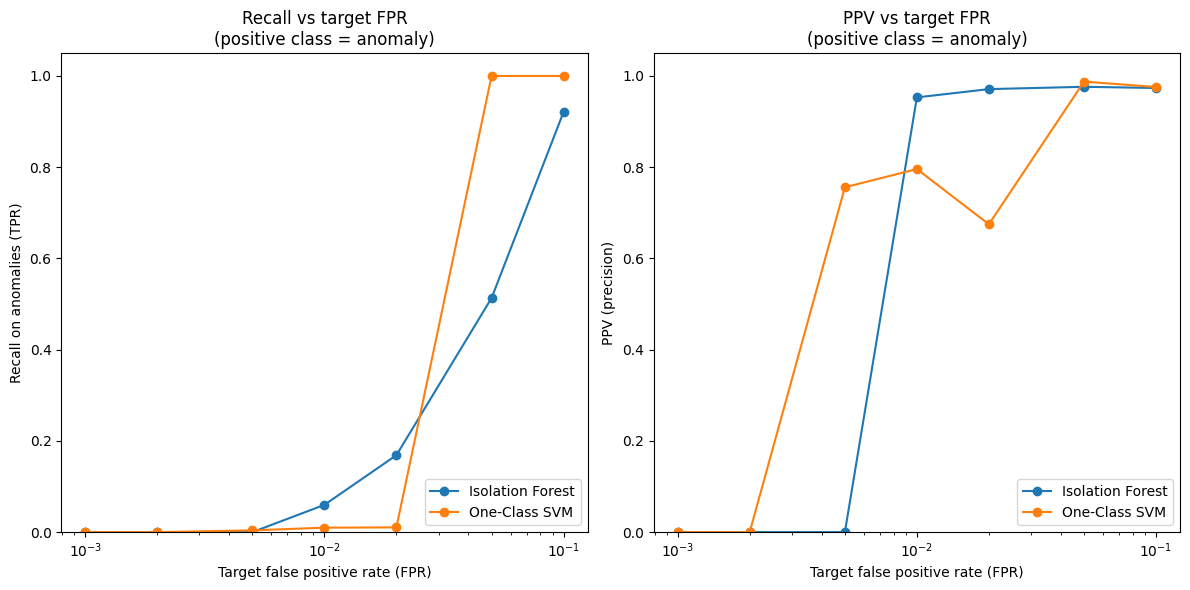

In [22]:
# --- Performance plots

label_map = {
    "iforest": "Isolation Forest",
    "ocsvm": "One-Class SVM"
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# ---- Left: Recall vs target FPR ----
ax = axes[0]
for name, sub in df_thr.groupby("model"):
    ax.plot(
        sub["target_fpr"],
        sub["recall_median"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log")
ax.set_xlabel("Target false positive rate (FPR)")
ax.set_ylabel("Recall on anomalies (TPR)")
ax.set_title("Recall vs target FPR\n(positive class = anomaly)")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")

# ---- Right: PPV vs target FPR ----
ax = axes[1]
for name, sub in df_thr.groupby("model"):
    ax.plot(
        sub["target_fpr"],
        sub["ppv_median"],
        marker="o",
        label=label_map.get(name, name)
    )

ax.set_xscale("log")
ax.set_xlabel("Target false positive rate (FPR)")
ax.set_ylabel("PPV (precision)")
ax.set_title("PPV vs target FPR\n(positive class = anomaly)")
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


#### Isolation Forest

- **PPV (precision)** increases smoothly as the target FPR is relaxed, reaching ~0.97 by FPR ≈ 0.02.
- **Recall** improves gradually with looser thresholds, without abrupt jumps.
- **Empirical FPR** closely tracks the target FPR across the tested range.

**Interpretation:** Isolation Forest exhibits a smooth and predictable precision–recall trade-off under threshold calibration, making it relatively easy to tune to different operating points.

#### One-Class SVM

- At low target FPRs, **PPV and recall** remain high when sufficient normal training data are available.
- As thresholds are relaxed, performance changes more abruptly than for Isolation Forest.
- Small changes in target FPR can lead to large swings in recall.

**Interpretation:** One-Class SVM shows sharper, less forgiving threshold behaviour, implying a narrower operating window and greater sensitivity to calibration choices.

---

### 4.5 Score distribution analysis and visualisation

To better understand the behaviour observed in the benchmarking and calibration experiments, we examine the **distribution of anomaly scores** produced by each model. Rather than focusing on discrete metrics or thresholds, this section looks directly at how each model separates normal and anomalous traffic in score space.

For each model, we:

- Plot histograms and Kernel Density Estimates (KDEs) of `decision_function` scores for:
  - normal flows
  - scan flows

We visualise score distributions using both histograms and KDEs: histograms show the raw score frequencies, while KDEs provide a smoothed view that helps explain calibration behaviour and threshold sensitivity.

We examine:

- how cleanly the two score distributions are separated
- whether scores are tightly clustered or broadly spread
- whether normal flows sit close to, or overlap with, the anomaly region

This analysis provides intuition for **why certain thresholds are forgiving or brittle**, and helps explain the different calibration and failure behaviours observed in earlier sections.


In [23]:
# --- Decision function analysis

# ---- controls ----
train_n = 2**12
threshold_fprs = [0.01, 0.05, 0.10]
bins = 50

# ---- prepare data ----
idx = rng.choice(len(df_pool), size=train_n, replace=False)
X_train = st.select_feature_matrix(df_pool.iloc[idx])
X_norm  = st.select_feature_matrix(df_hold)
X_anom  = st.select_feature_matrix(df_anom_all)

models = {
    "Isolation Forest": st.fit_iforest(X_train, contamination=0.05),
    "One-Class SVM":    st.fit_ocsvm(X_train, nu=0.05, gamma="scale"),
}

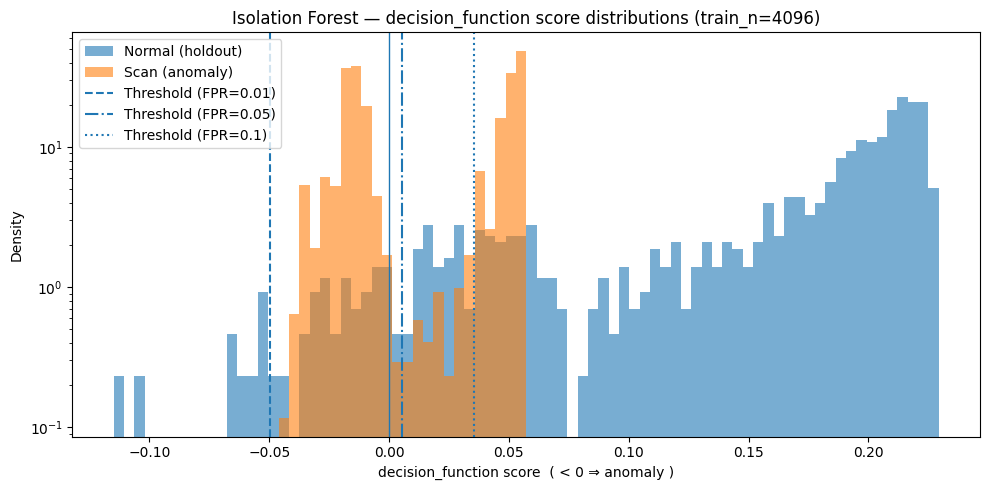

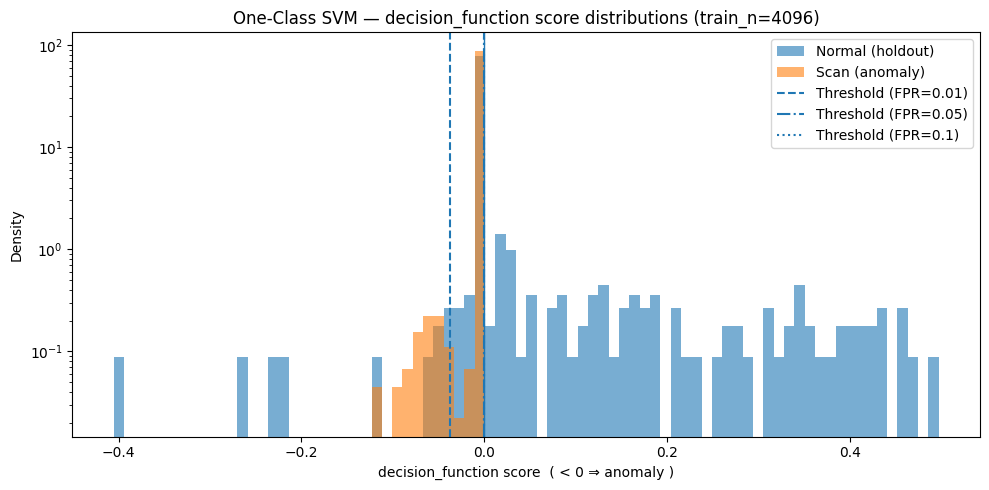

In [24]:
# --- Plotting histograms

# ---- controls ----
train_n = 2**12
threshold_fprs = [0.01, 0.05, 0.10]
bins = 80                 # more bins for a closer look
zoom = False              # set False to show full range
zoom_window = 0.25        # show scores in [-zoom_window, +zoom_window] around 0
use_logy = True          # set True to see tails

# ---- prepare data once ----
idx = rng.choice(len(df_pool), size=train_n, replace=False)
X_train = st.select_feature_matrix(df_pool.iloc[idx])
X_norm  = st.select_feature_matrix(df_hold)
X_anom  = st.select_feature_matrix(df_anom_all)

models = {
    "Isolation Forest": st.fit_iforest(X_train, contamination=0.05),
    "One-Class SVM":    st.fit_ocsvm(X_train, nu=0.05, gamma="scale"),
}

linestyle_map = {
    0.01: "--",   # dashed
    0.05: "-.",   # dash-dot
    0.10: ":"     # dotted
}

def plot_scores_one_model(name, model):
    scores_norm = model.decision_function(X_norm)
    scores_anom = model.decision_function(X_anom)

    # common bin edges for fair overlay
    all_scores = np.concatenate([scores_norm, scores_anom])
    if zoom:
        lo, hi = -zoom_window, zoom_window
        all_scores = all_scores[(all_scores >= lo) & (all_scores <= hi)]
        # fallback if zoom window clips everything
        if len(all_scores) < 10:
            all_scores = np.concatenate([scores_norm, scores_anom])

    bin_edges = np.histogram_bin_edges(all_scores, bins=bins)

    plt.figure(figsize=(10, 5))
    plt.hist(scores_norm, bins=bin_edges, density=True, alpha=0.6, label="Normal (holdout)")
    plt.hist(scores_anom, bins=bin_edges, density=True, alpha=0.6, label="Scan (anomaly)")

    # threshold lines from normal holdout quantiles
    for fpr in threshold_fprs:
        thresh = float(np.quantile(scores_norm, fpr))
        plt.axvline(
            thresh,
            linestyle=linestyle_map.get(fpr, "--"),
            linewidth=1.5,
            label=f"Threshold (FPR={fpr})"
        )

    # reference line at 0 (sklearn convention boundary)
    plt.axvline(0.0, linestyle="-", linewidth=1)

    plt.title(f"{name} — decision_function score distributions (train_n={train_n})")
    plt.xlabel("decision_function score  ( < 0 ⇒ anomaly )")
    plt.ylabel("Density")
    if use_logy:
        plt.yscale("log")

    if zoom:
        plt.xlim(-zoom_window, zoom_window)

    plt.legend()
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    plot_scores_one_model(name, model)


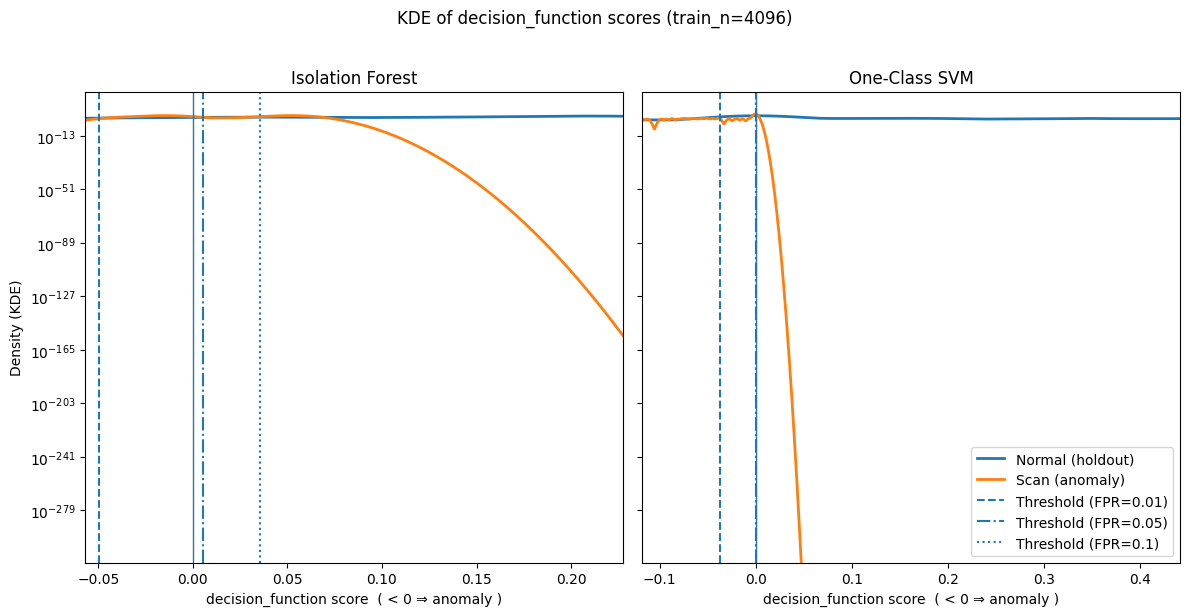

In [25]:
# --- Plotting KDEs

from scipy.stats import gaussian_kde

# --- KDE controls ---
kde_points = 800
kde_bw = "scott"   # or float multiplier, e.g. 0.8

linestyle_map = {
    0.01: "--",
    0.05: "-.",
    0.10: ":"
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for ax, (name, model) in zip(axes, models.items()):
    scores_norm = model.decision_function(X_norm)
    scores_anom = model.decision_function(X_anom)

    all_scores = np.concatenate([scores_norm, scores_anom])

    # x-range selection
    if zoom:
        lo, hi = -zoom_window, zoom_window
    else:
        lo = float(np.quantile(all_scores, 0.001))
        hi = float(np.quantile(all_scores, 0.999))
        if lo == hi:
            lo, hi = float(all_scores.min()), float(all_scores.max())

    x = np.linspace(lo, hi, kde_points)

    # KDE objects
    kde_norm = gaussian_kde(scores_norm)
    kde_anom = gaussian_kde(scores_anom)

    if isinstance(kde_bw, (int, float)):
        kde_norm.set_bandwidth(bw_method=kde_norm.factor * kde_bw)
        kde_anom.set_bandwidth(bw_method=kde_anom.factor * kde_bw)
    else:
        kde_norm.set_bandwidth(bw_method=kde_bw)
        kde_anom.set_bandwidth(bw_method=kde_bw)

    ax.plot(x, kde_norm(x), label="Normal (holdout)", linewidth=2)
    ax.plot(x, kde_anom(x), label="Scan (anomaly)", linewidth=2)

    # threshold lines
    for fpr in threshold_fprs:
        thresh = float(np.quantile(scores_norm, fpr))
        ax.axvline(
            thresh,
            linestyle=linestyle_map.get(fpr, "--"),
            linewidth=1.5,
            label=f"Threshold (FPR={fpr})"
        )

    # sklearn decision boundary
    ax.axvline(0.0, linestyle="-", linewidth=1)

    ax.set_title(f"{name}")
    ax.set_xlabel("decision_function score  ( < 0 ⇒ anomaly )")

    if use_logy:
        ax.set_yscale("log")

    ax.set_xlim(lo, hi)

axes[0].set_ylabel("Density (KDE)")
axes[1].legend(loc="best")

plt.suptitle(f"KDE of decision_function scores (train_n={train_n})", y=1.02)
plt.tight_layout()
plt.show()


Examining the raw `decision_function` score distributions helps explain the markedly different behaviours observed in the benchmarking and threshold calibration experiments. We visualise these distributions using both histograms and kernel density estimates (KDEs): histograms show the empirical score frequencies directly, while KDEs provide a smoothed view that makes overall structure, overlap, and tail behaviour easier to interpret. KDEs are used here purely as a qualitative aid; all quantitative conclusions are grounded in the raw scores.

**Isolation Forest** produces broad, overlapping score distributions for normal and scan flows. Normal traffic spans a wide range of positive scores, with a long tail approaching and occasionally crossing the decision boundary at zero. Scan flows are shifted left on average but overlap substantially with the distribution of normal flows. While this overlap is visible in the histograms, the KDEs make clear that there is no sharp separation between the two classes. Instead, threshold selection induces a smooth and continuous trade-off: relaxing the threshold gradually increases recall while steadily admitting more false positives. This explains the model’s stable, predictable behaviour and its graceful degradation as training data becomes scarce.

**One-Class SVM**, by contrast, produces highly concentrated score distributions. Normal flows lie almost entirely on the positive side of the boundary, while scan flows collapse into a narrow band just below zero. The histograms already suggest this strong separation, but the KDEs emphasise how little probability mass lies in the ambiguous region near the boundary. Consequently, small changes in the decision threshold have dramatic effects: below the boundary the model detects almost nothing, while just above it recall jumps abruptly to near-perfect levels. This hard geometric separation explains both the model’s excellent performance when well-calibrated and its brittle, cliff-edge behaviour when thresholds or training conditions are even slightly misspecified.

These plots show that the two models differ not merely in performance metrics, but in the *geometry of the anomaly scores they produce*. This geometric difference directly governs how thresholds behave in practice and helps explain the contrasting calibration and failure modes observed earlier.


## 5. Conclusions

This notebook examined how two one-class anomaly detection methods — Isolation Forest and One-Class SVM — behave on controlled network flow data, with an emphasis on robustness, scalability and calibration behaviour rather than headline detection performance.

Across the experiments, a consistent pattern emerged. **Isolation Forest** behaved as a *soft, probabilistic anomaly scorer*: its decisions were fuzzy but stable, its computational cost scaled smoothly with training size and its detection performance degraded gradually as normal training data or calibration quality declined. This behaviour was reflected in the geometry of its anomaly scores, which formed broad, overlapping distributions and produced a smooth, forgiving trade-off between false positives and missed detections as thresholds were adjusted.

By contrast, **One-Class SVM** behaved as a *hard boundary detector*. When supplied with sufficient and representative normal training data, and when carefully calibrated, it achieved extremely strong separation between normal and anomalous traffic. However, both its computational cost and its detection behaviour proved highly sensitive to training size and threshold choice. As normal training data became limited, performance degraded abruptly rather than gradually. This brittleness was explained by the highly concentrated geometry of its score distributions, which created a narrow operating window and cliff-edge behaviour under even small calibration errors.

These results show that the two models differ not merely in performance metrics, but in the *structure of the anomaly scores they produce*. These geometric differences directly govern how each model behaves under data scarcity, threshold uncertainty and imperfect supervision, and help explain why Isolation Forest is easier to tune conservatively while One-Class SVM demands careful calibration to avoid catastrophic failure modes.

From an operational perspective, the separation of training and inference costs provides additional insight into how each model might behave when scaled up, retrained frequently or deployed alongside other detectors. In this light, Isolation Forest appears well suited to roles such as early-stage anomaly filtering, where stability and predictability are prioritised, while One-Class SVM may be better reserved for more focused or downstream analysis when ample representative training data can be guaranteed.

**Practical takeaway:**  
In settings where data volume, representativeness or operating conditions may vary over time, Isolation Forest appears to be the safer general-purpose baseline. One-Class SVM can outperform it substantially when sufficient, representative normal data are available, but carries higher operational risk in dynamic or weakly supervised environments.

More broadly, these findings illustrate an important principle for one-class anomaly detection in security contexts: strong performance on clean, synthetic data does not guarantee robustness under drift, noise or partial observability. Models should therefore be treated not as standalone detectors, but as **components within a broader analytical pipeline**, complemented by domain knowledge, monitoring of score distributions over time and careful calibration practices.

Overall, this notebook establishes a controlled behavioural baseline for one-class anomaly detection on network flow data, providing a foundation for more realistic data, alternative models, and deployment-oriented analyses in future work.


---

## 6. Future Directions

This notebook establishes a **controlled behavioural baseline** for two one-class anomaly detectors.
Future work can extend this analysis along two complementary axes.

### 6.1 Varying the data-generating process

One natural extension is to relax the assumptions about “normal” and “anomalous” traffic, while keeping the modelling approach fixed. For example:

- Increase heterogeneity in normal behaviour:
  - mix protocols (HTTP, DNS, ICMP)
  - vary traffic rates and burstiness
- Introduce more subtle anomalies:
  - low-and-slow scans
  - scans embedded within otherwise normal sessions

Departures from the clean behaviour observed here would then be interpretable as consequences of increased data complexity, rather than modelling artefacts.

### 6.2 Alternative model assessment and modelling strategies

A second extension axis is to probe model behaviour using different analytical lenses, without necessarily changing the data:

- Compare additional lightweight anomaly detectors:
  - other tree-based methods
  - shallow ensembles
  - random ferns or small random forests
- Examine alternative calibration strategies:
  - adaptive or quantile-based thresholds
  - time-windowed calibration
- Explore pipeline placement:
  - coarse early-stage filtering vs downstream focused analysis

### 6.3 Transitioning to real-world network traffic

A further, more advanced extension would be to apply similar analysis techniques to examples of network traffic captured “in the wild”, using publicly available datasets or controlled capture environments.

This would introduce additional challenges absent from the current notebook, including:
- heterogeneous and evolving normal behaviour
- unclear or partial ground truth
- greater sensitivity to feature design and preprocessing
- the likelihood that simple one-class models require adaptation or augmentation

In this sense, the models explored here should be viewed as **starting points** rather than final solutions. The controlled analysis in this notebook provides a necessary baseline for understanding failure modes and limitations before engaging with real-world data.


Together, these extensions would help clarify **where different one-class methods are best placed within a broader detection pipeline**, rather than simply which performs best on a single dataset.

---

# Appendix 

## Benchmark output variables

The table below reports timing and performance metrics collected during the speed and stability benchmarking of the one-class models.  
All metrics are aggregated across repeated runs at each training size.

**Naming convention:**  
Variables ending in `_md` denote the **median** value across all repetitions for a given configuration. The median is used to reduce sensitivity to timing noise and outliers.

#### Identification and configuration

- **model**  
  The anomaly detection model used.  
  Values: `iforest`, `ocsvm`.

- **positive_class**  
  The class treated as *positive* for all performance metrics.  
  In this benchmark: `anomaly` (label = 1).

- **i**  
  Iteration index controlling training set size.  
  Training size is approximately `n_train = floor(N_trainpool / 2^i)`.

- **n_train**  
  Number of normal flow samples used for training the model in this iteration.

- **n_hold**  
  Number of normal flow samples in the **fixed holdout set** used for:
  - threshold calibration (if enabled)
  - evaluation of false positives and NPV

#### Timing metrics

- **fit_time_md**  
  Median wall-clock time (seconds) required to train the model on `n_train` samples.

- **infer_time_md**  
  Median wall-clock time (seconds) required to:
  - score the fixed normal holdout set  
  - score the full anomaly dataset  
  - apply thresholding and generate predictions  

  This approximates real-world inference cost per evaluation batch.

#### Performance metrics (positive class = anomaly)

- **ppv_md** (Positive Predictive Value / Precision)  
  Median precision:  
  $$\text{PPV} = \frac{TP}{TP + FP}$$  
  Interpreted as: *When the model flags an anomaly, how often is it correct?*

- **npv_md** (Negative Predictive Value)  
  Median NPV:  
  $$\text{NPV} = \frac{TN}{TN + FN}$$  
  Interpreted as: *When the model predicts “normal”, how often is that correct?*

- **recall_md**  
  Median recall (true positive rate):  
  $$\text{Recall} = \frac{TP}{TP + FN}$$
  Measures the fraction of anomalies successfully detected.

- **f1_md**  
  Median F1 score (harmonic mean of PPV and recall):
  $$F1 = \frac{2 \cdot (\text{PPV} \cdot \text{Recall})}{\text{PPV} + \text{Recall}}$$

- **fpr_md**  
  Median false positive rate on the **normal holdout set**:
  $$\text{FPR} = \frac{FP}{FP + TN}$$
  When threshold calibration is enabled, this value should approximate the target FPR, subject to finite-sample effects.

#### Notes

- All performance metrics are evaluated on the same fixed evaluation set:
  - normal holdout flows  
  - all scan (anomalous) flows
- The table is intended to support **comparative analysis of scaling behaviour**, not to optimise absolute detection performance.
- Timing and metric trends across training sizes are more informative than any single row.


## Kernel density estimation (KDE)

Kernel density estimation (KDE) provides a smooth, continuous estimate of the underlying probability density function of a random variable, based on a finite set of samples. Rather than counting observations in discrete bins (as in a histogram), KDE places a small, smooth kernel function at each data point and sums their contributions to obtain an overall density estimate.

Formally, given samples $x_1, \ldots, x_n$, the KDE at location $x$ is:

$$\hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n} K\!\left( \frac{x - x_i}{h} \right)$$

where:
- $K(\cdot)$ is the kernel function (commonly Gaussian),
- $h > 0$ is the bandwidth parameter controlling the degree of smoothing.

The choice of bandwidth determines the trade-off between smoothness and fidelity to the empirical data: small bandwidths can produce noisy, highly variable estimates, while large bandwidths can obscure structure by over-smoothing.

In this notebook, KDEs are used **purely as a qualitative visual aid** to help interpret the geometry of anomaly score distributions, particularly overlap, tail behaviour, and separation between normal and anomalous traffic. All quantitative evaluation, threshold calibration, and performance metrics are computed directly from the raw `decision_function` scores, not from the KDE estimates themselves.





---

***A compressed, recruiter-facing “showcase” version is derived from this notebook is also available in the repo.***

---